In [2]:
import argparse
import os
import random
import json
import shutil
import time
import warnings
import torch.cuda as cuda
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch.utils.data import DataLoader
import numpy as np
from logger import Logger
import os
from torch.nn.modules.loss import _Loss
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import PIL.Image as Image
import Model_zoo as models
import matplotlib.colors as colors
import cv2
denormalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                        std=[1/0.229, 1/0.224, 1/0.225])
toPIL = T.Compose([denormalize, T.ToPILImage()])

/usr/local/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### You need Download following checkpoints~

In [3]:
device_ids = [1,0]
gpu = 1
model_path1 = "./model_checkpoints/checkpoint_CUB200_vgg16_bn_lr-2_sd0_itr300.pth.tar"
model_path2 = "./model_checkpoints/checkpoint_CUB200_vgg16_bn_lr-2_sd5_itr300.pth.tar"
image_path = "../image/"
resume = "./model_checkpoints/checkpoint_L30__a0.1_lr-4.pth.tar"
dataset = 'CUB200'
conv_layer = 30
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
arch = 'vgg16_bn'

In [4]:
def load_checkpoint(resume, model):
    if os.path.isfile(resume):
        print("=> loading checkpoint '{}'".format(resume))
        checkpoint = torch.load(resume, map_location=torch.device("cuda:{}".format(device_ids[0])))
        state_dict = checkpoint['state_dict']
        keys = list(state_dict.keys())
        for key in keys:
            if key.find('module') >= 0:
                state_dict[key.replace('module.','')] = state_dict.pop(key)

        model.load_state_dict(state_dict)
        print("=> loaded checkpoint '{}' (epoch {} acc1 {})"
              .format(resume, checkpoint['epoch'], checkpoint['best_acc1']))
    else:
        print("=> no checkpoint found at '{}'".format(resume))

In [5]:
def ResBlock_beforeReLU(block, x): # Only for ResNet 50 101 152!!
    identity = x

    out = block.conv1(x)
    out = block.bn1(out)
    out = block.relu(out)

    out = block.conv2(out)
    out = block.bn2(out)
    if block.__class__.__name__ != 'BasicBlock':
        out = block.relu(out)

        out = block.conv3(out)
        out = block.bn3(out)

    if block.downsample is not None:
        identity = block.downsample(x)

    out += identity
    return out

def get_feature(img, net):
    input = img.unsqueeze(0)
    net.eval()
    with torch.no_grad():
        if arch.startswith("alexnet"):
            x = net.features[:conv_layer + 1](input)

        elif arch.startswith("vgg"):
            x = net.features[:conv_layer + 1](input)


        elif arch.startswith("resnet"):
            x = input
            x = net.conv1(x)
            x = net.bn1(x)
            x = net.relu(x)
            x = net.maxpool(x)

            x = net.layer1(x)
            x = net.layer2(x)
            x = net.layer3[:-1](x)
            x = ResBlock_beforeReLU(net.layer3[-1], x)

        return x.squeeze()

In [6]:
net1 = models.__dict__[arch](num_classes=200)
load_checkpoint(model_path1, net1)
net2 = models.__dict__[arch](num_classes=200)
load_checkpoint(model_path2, net2)


=> loading checkpoint '../pickedModel/checkpoint_CUB200_vgg16_bn_lr-2_sd0_itr300.pth.tar'
=> loaded checkpoint '../pickedModel/checkpoint_CUB200_vgg16_bn_lr-2_sd0_itr300.pth.tar' (epoch 300 acc1 43.21712112426758)
=> loading checkpoint '../pickedModel/checkpoint_CUB200_vgg16_bn_lr-2_sd5_itr300.pth.tar'
=> loaded checkpoint '../pickedModel/checkpoint_CUB200_vgg16_bn_lr-2_sd5_itr300.pth.tar' (epoch 300 acc1 43.30341720581055)


In [7]:
traindir = "../image"
image_dataset = datasets.ImageFolder(
        traindir, T.Compose([
            T.Resize((224,224)),
            T.ToTensor(),
            normalize,
        ]))

In [8]:
x = get_feature(image_dataset[0][0], net1)

In [9]:
input_size = x.shape
output_size = x.shape

In [10]:
print (input_size)

torch.Size([512, 28, 28])


In [14]:
model = models.LinearTester(input_size,output_size, gpu_id= gpu, affine=False, bn = False, instance_bn=True).cuda(gpu)
checkpoint = torch.load(resume, map_location=torch.device("cuda:{}".format(gpu)))
model.load_state_dict(checkpoint['state_dict'])
del checkpoint

In [15]:
def vis(y, t, i, h=3,w=4,universal = True):
    cmap = 'jet'
    fig1, axes = plt.subplots(h,w,figsize=(10,10))

    im0 = axes[0][0].imshow(toPIL(image_dataset[i][0]))
    for k in range(1,h*w):
        if universal:
            im1 = axes[k//w][k%w].imshow(y[t[k-1]],cmap=cmap,vmax=y.max(), vmin=y.min())
        else:
            im1 = axes[k//w][k%w].imshow(y[t[k-1]],cmap=cmap)
    fig1.tight_layout()
    fig1.subplots_adjust(right=0.8)
    cbar_ax2 = fig1.add_axes([0.85, 0.10, 0.05, 0.80])
    fig1.colorbar(im1, cax=cbar_ax2)
    plt.show()
    plt.close()

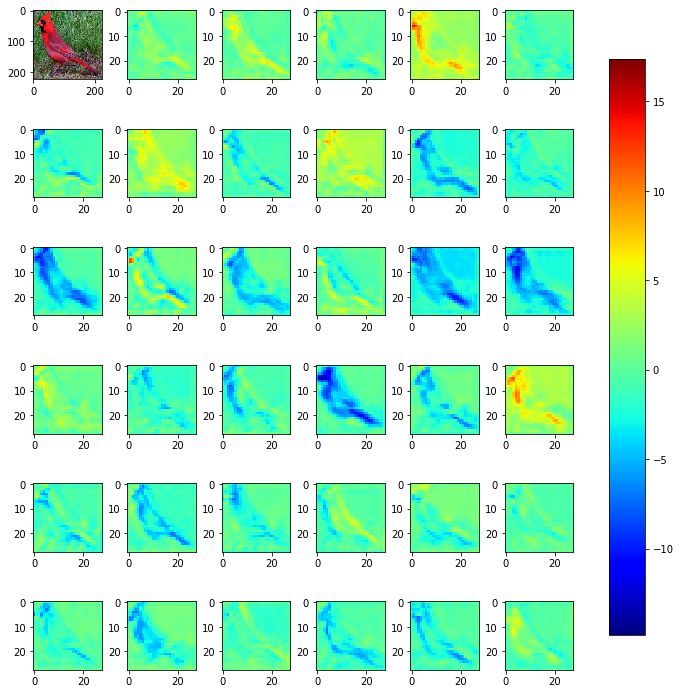

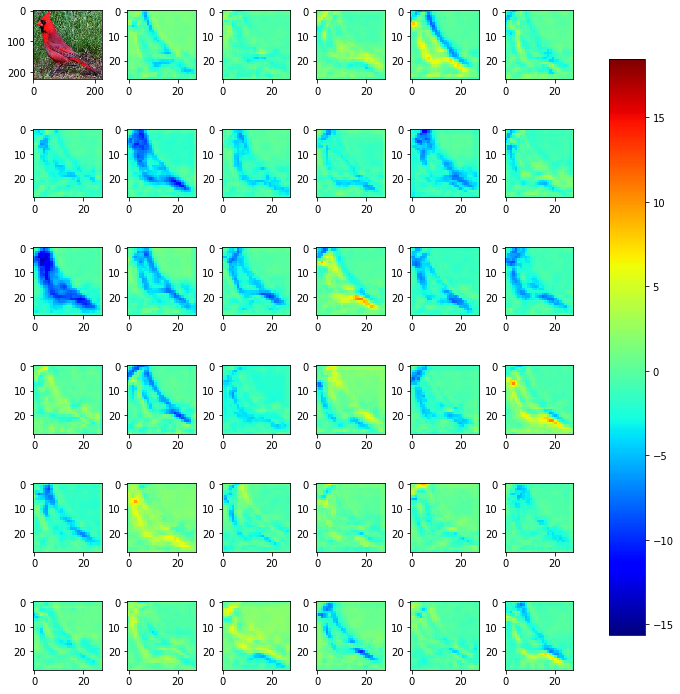

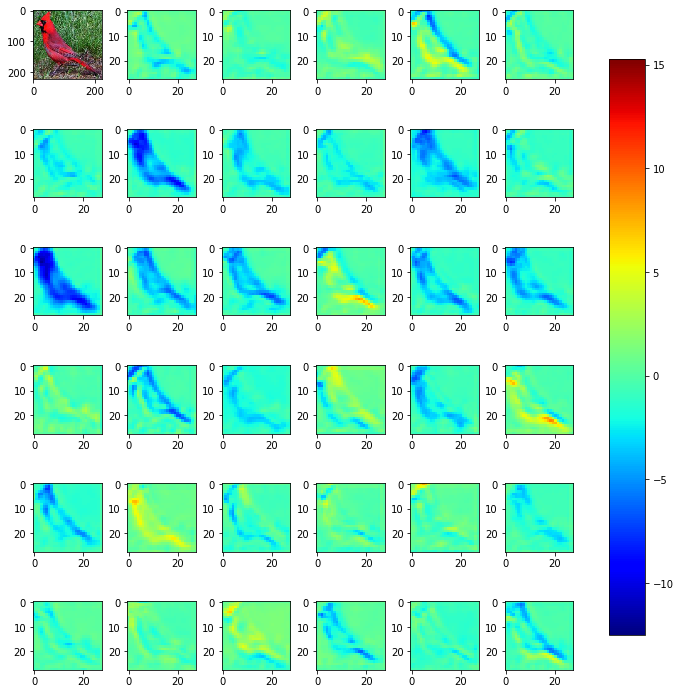

In [16]:
bird = 0 
input = get_feature(image_dataset[bird][0],net1)
target = get_feature(image_dataset[bird][0],net2)
vis(input, np.arange(35)*2, bird,6,6,1)
vis(target, np.arange(35)*2, bird,6,6,1)
input = input.unsqueeze(0).cuda(gpu)
model.eval()
output, output_n, output_contrib, res = model.val_linearity(input)
vis(output, np.arange(35)*2, bird,6,6,1)

Channel:  0
[0.16494042 0.28192914]


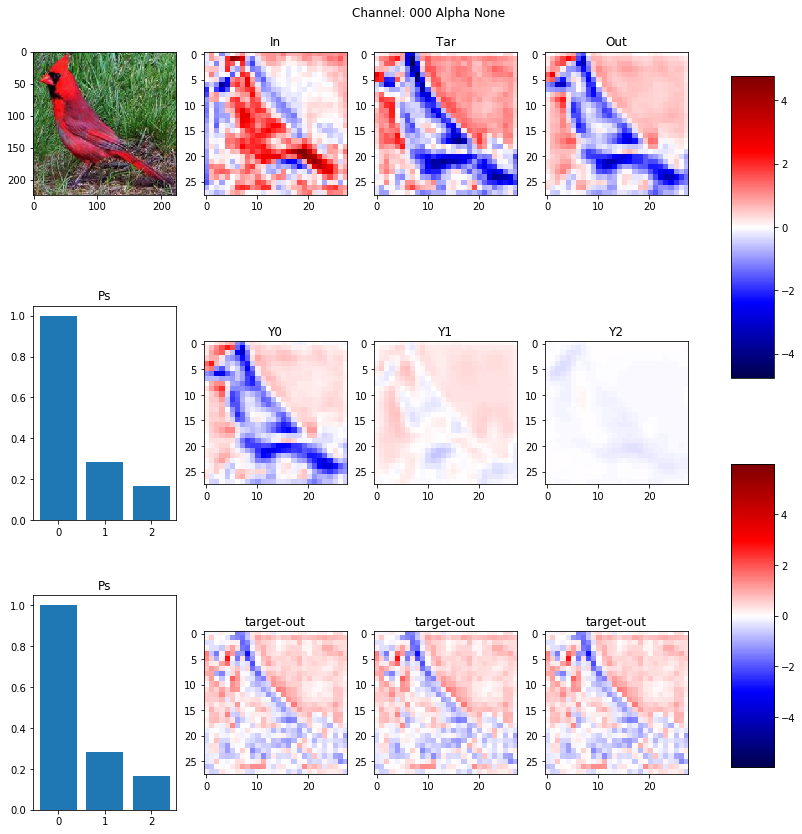

Channel:  50
[0.16494042 0.28192914]


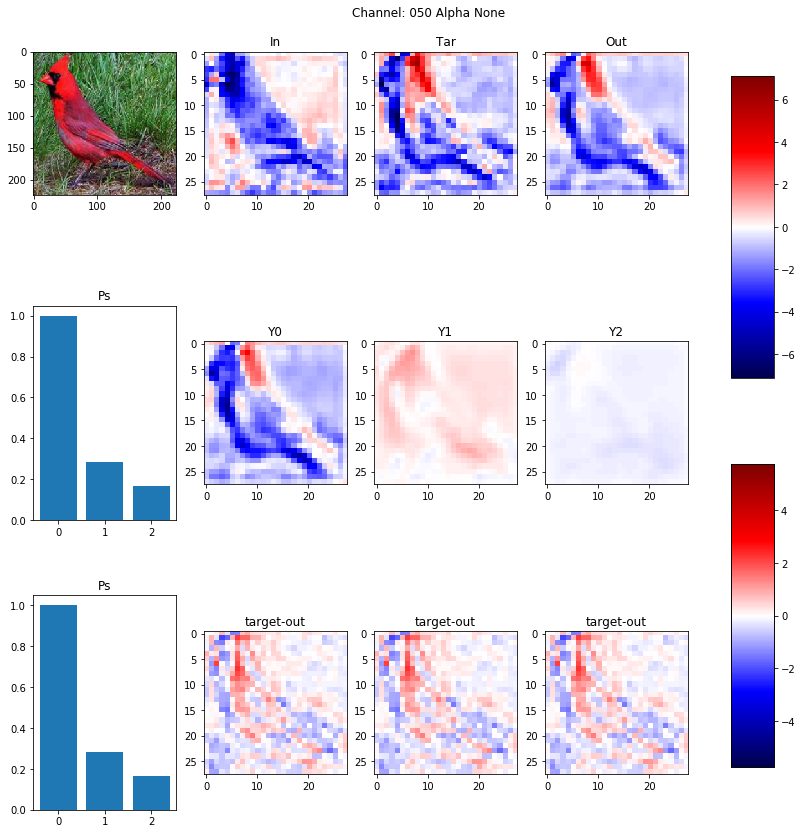

Channel:  100
[0.16494042 0.28192914]


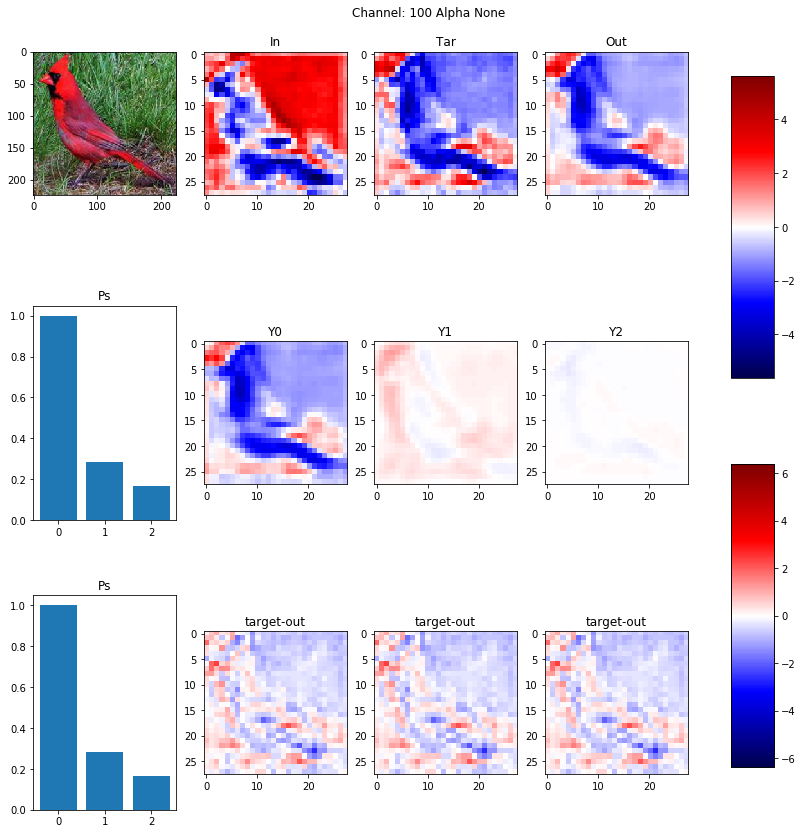

Channel:  150
[0.16494042 0.28192914]


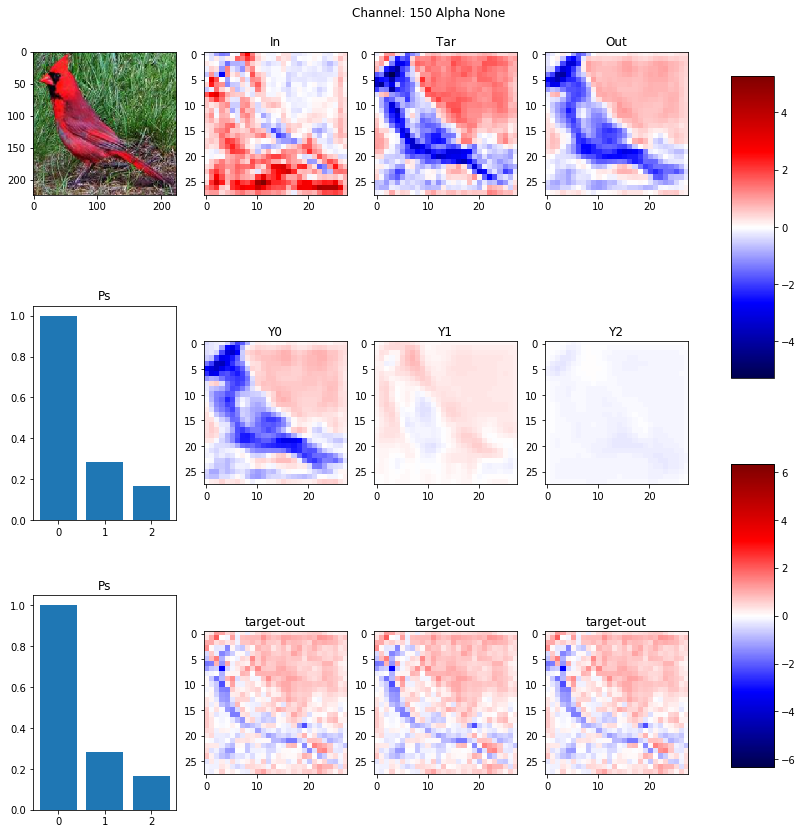

Channel:  200
[0.16494042 0.28192914]


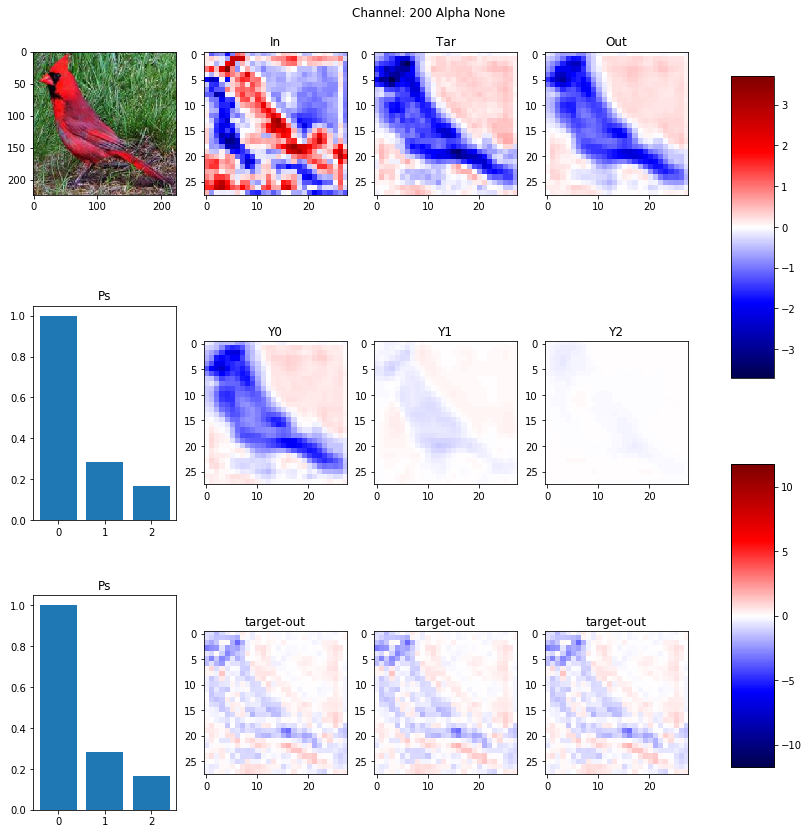

Channel:  250
[0.16494042 0.28192914]


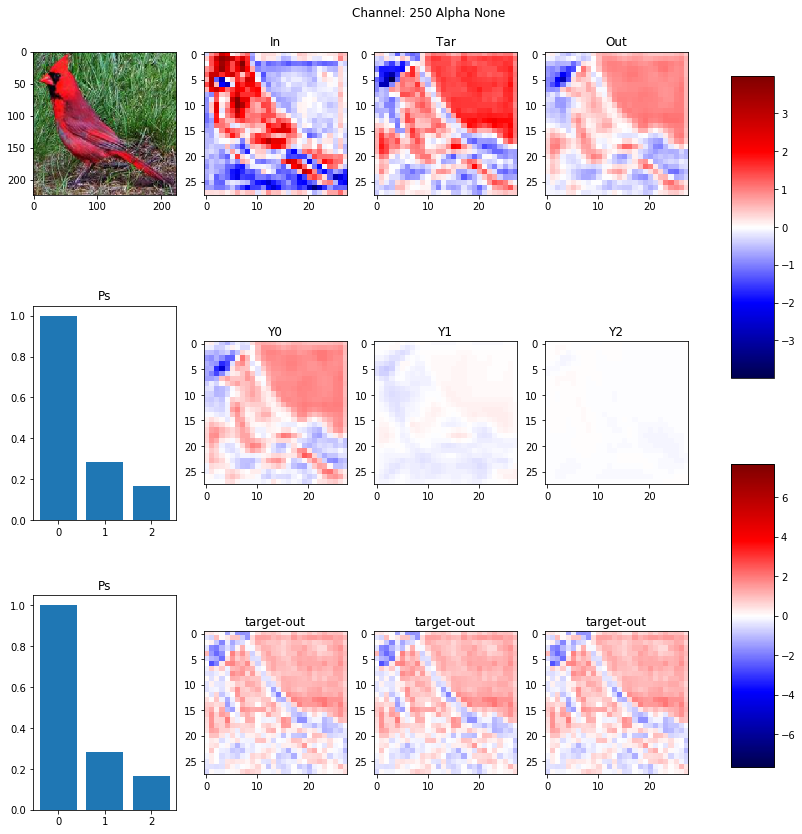

Channel:  300
[0.16494042 0.28192914]


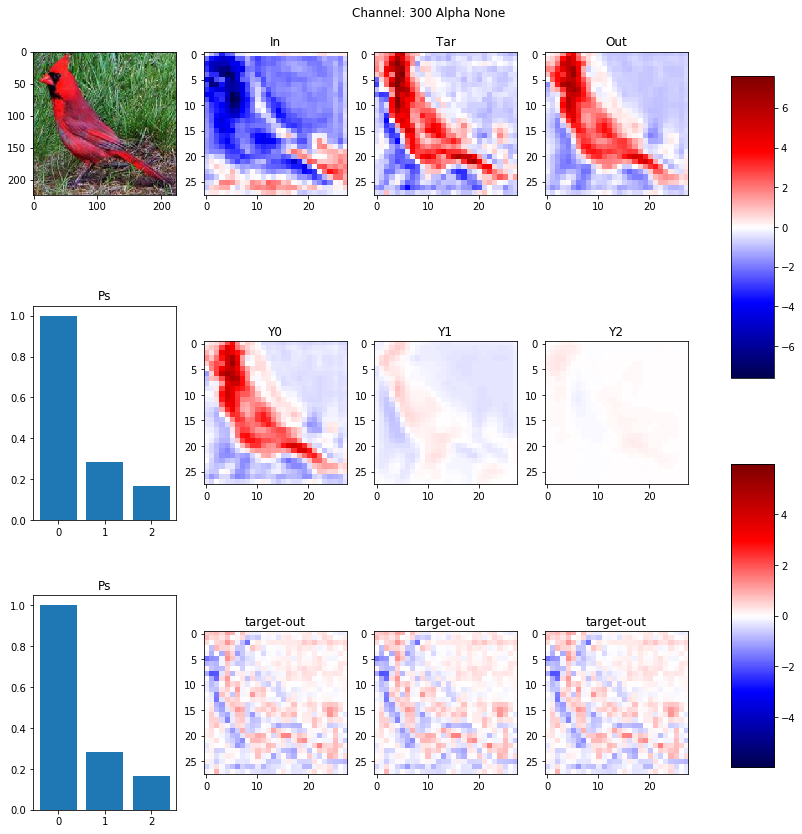

Channel:  350
[0.16494042 0.28192914]


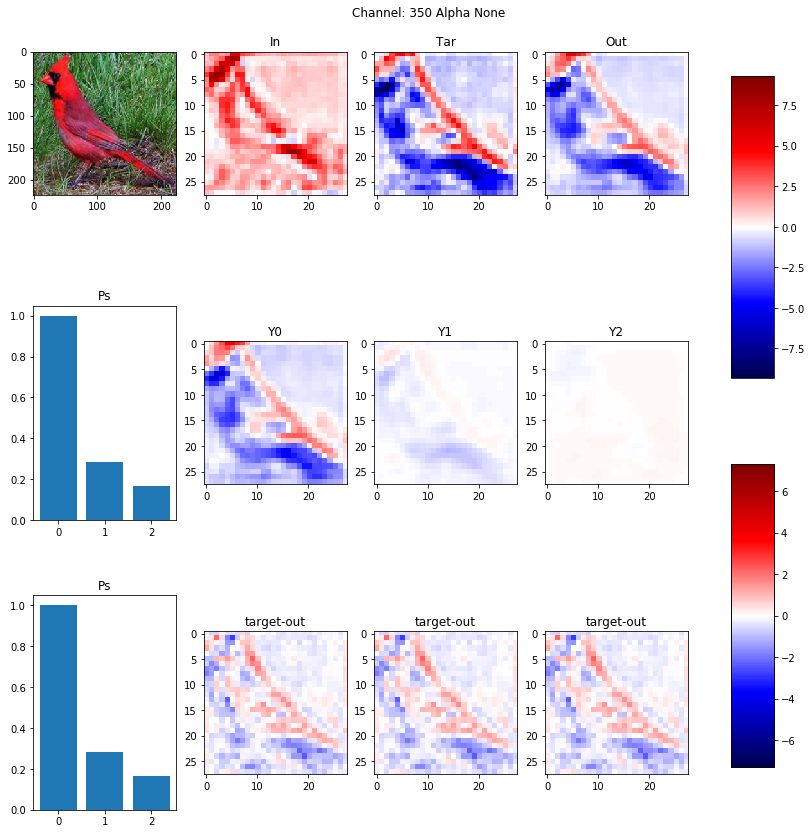

Channel:  400
[0.16494042 0.28192914]


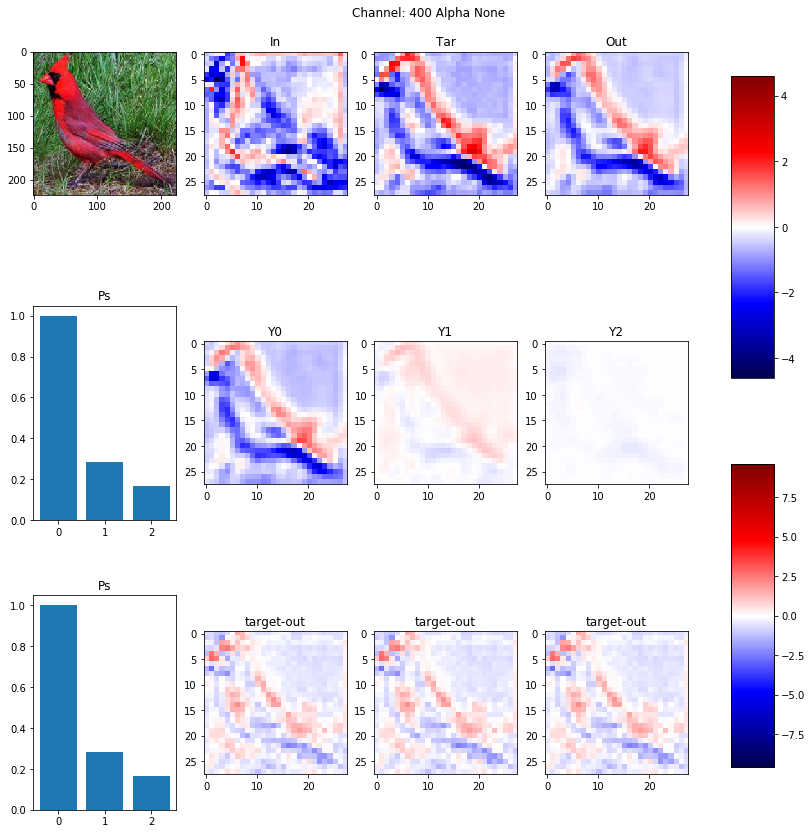

Channel:  450
[0.16494042 0.28192914]


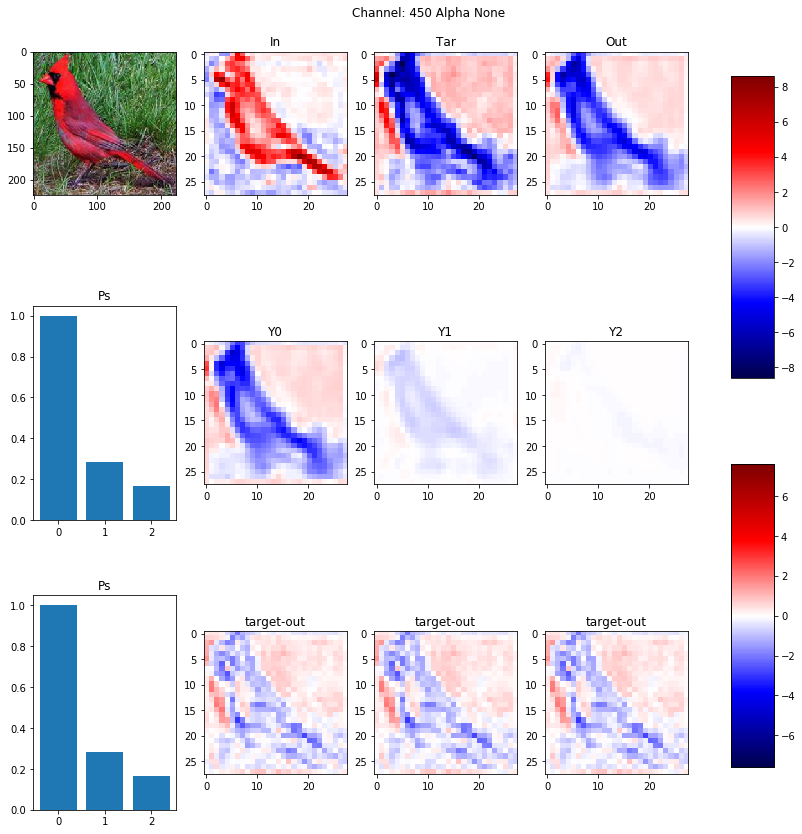

Channel:  500
[0.16494042 0.28192914]


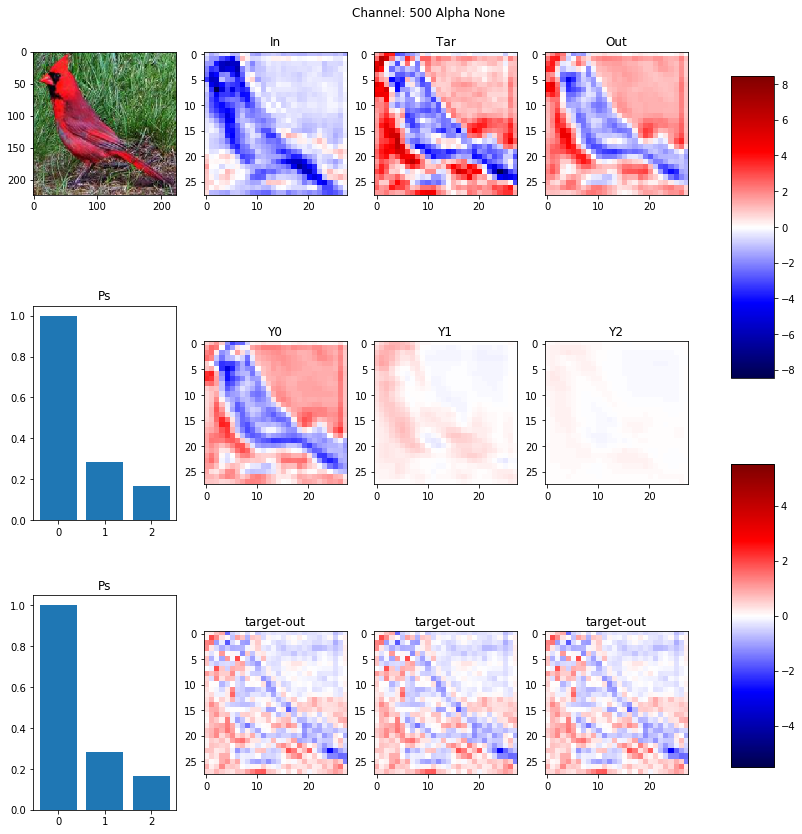

Channel:  0
[0.16494042 0.28192914]


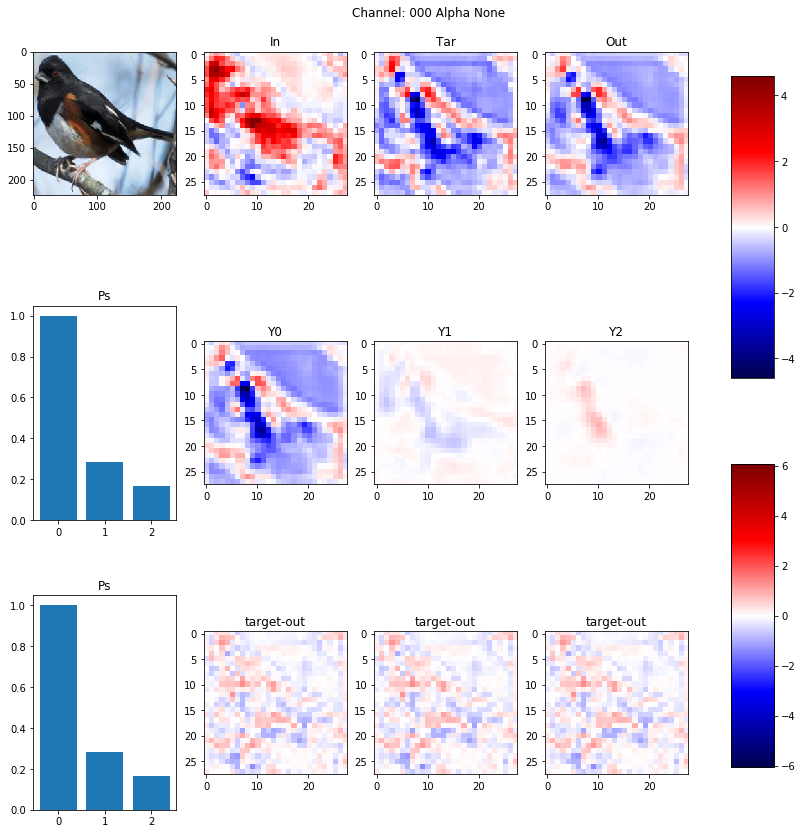

Channel:  50
[0.16494042 0.28192914]


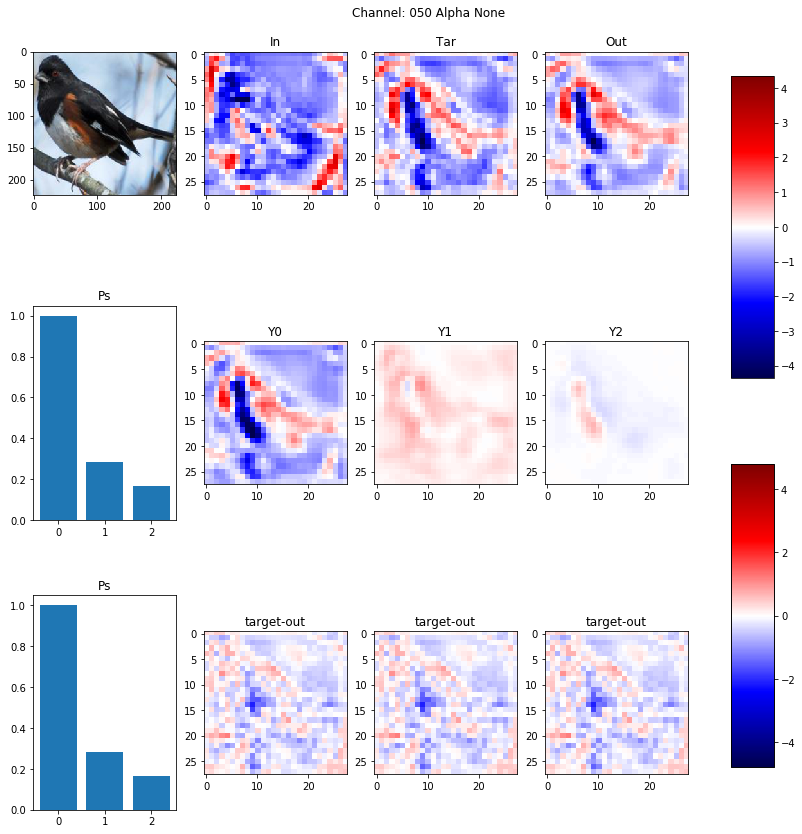

Channel:  100
[0.16494042 0.28192914]


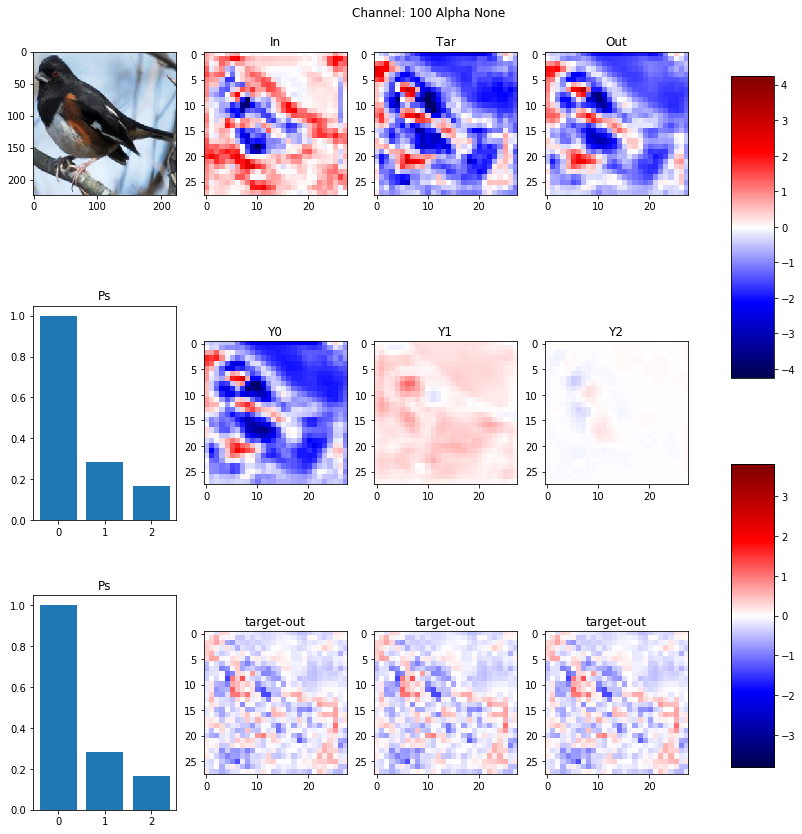

Channel:  150
[0.16494042 0.28192914]


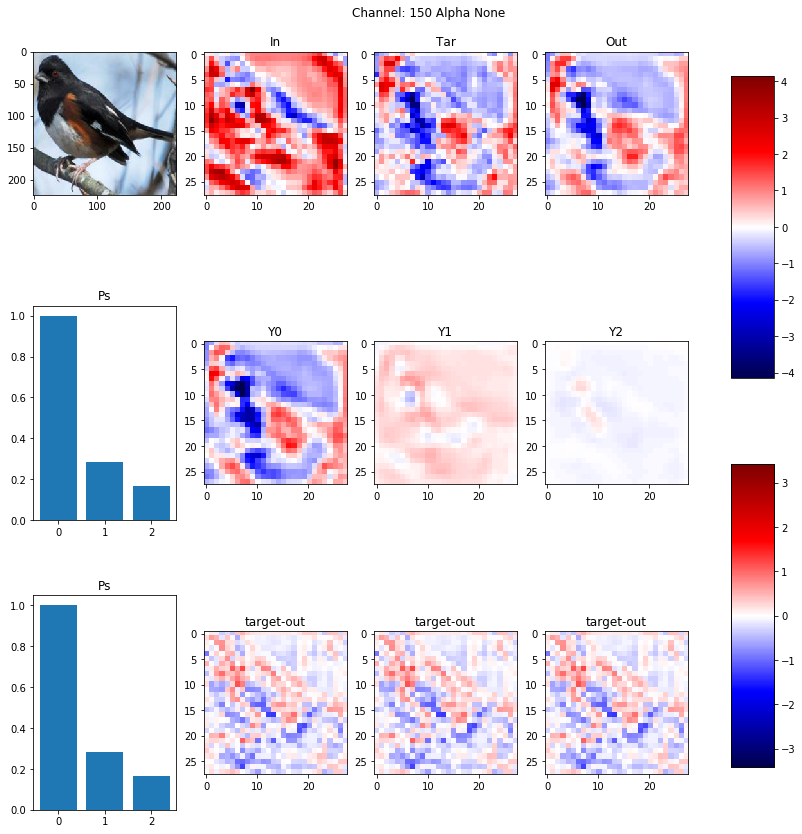

Channel:  200
[0.16494042 0.28192914]


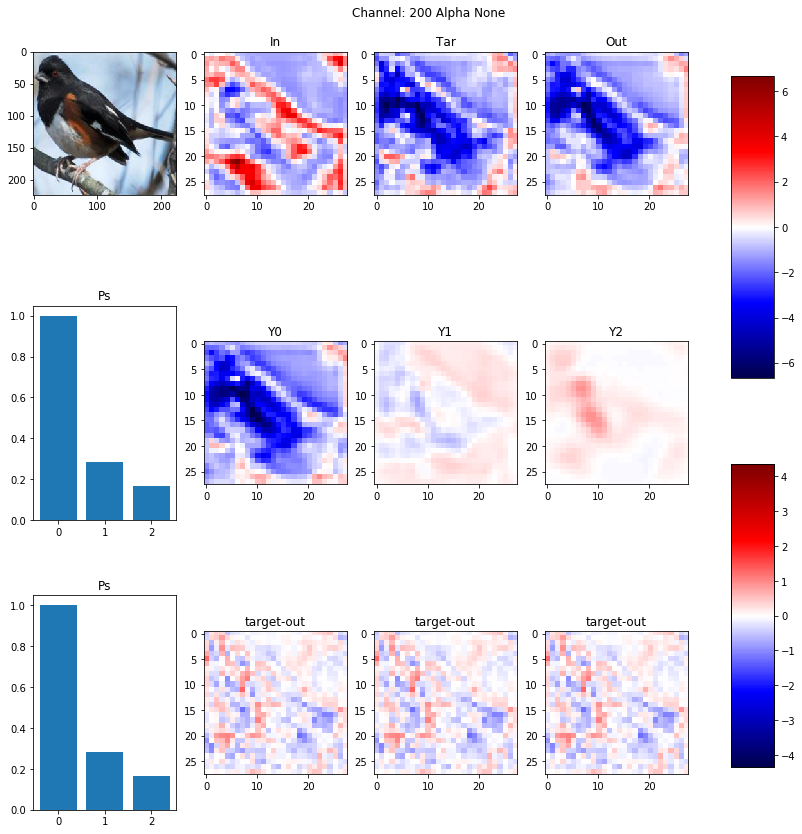

Channel:  250
[0.16494042 0.28192914]


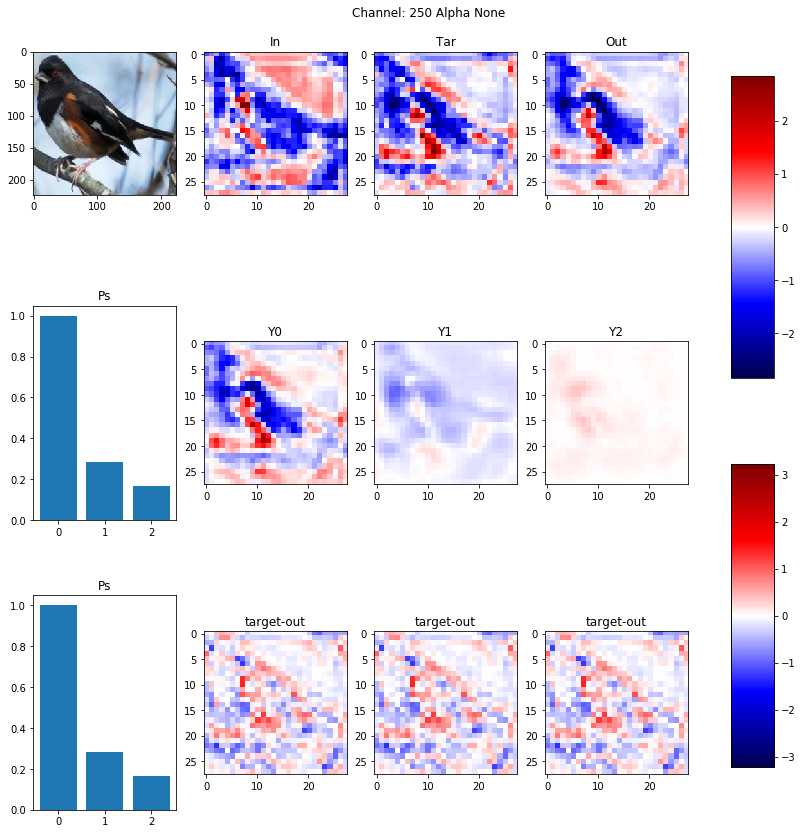

Channel:  300
[0.16494042 0.28192914]


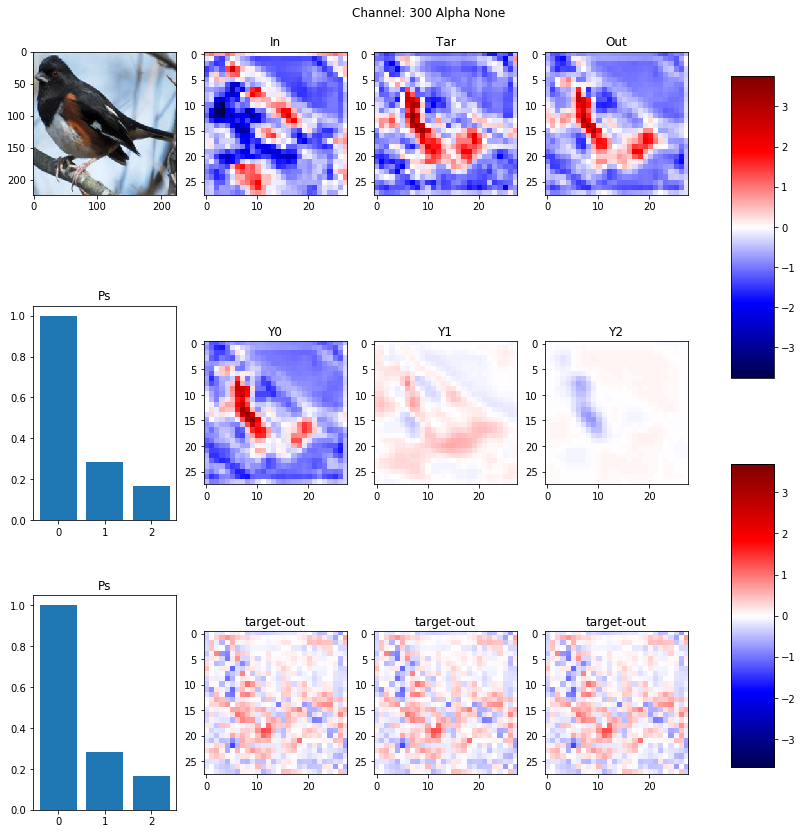

Channel:  350
[0.16494042 0.28192914]


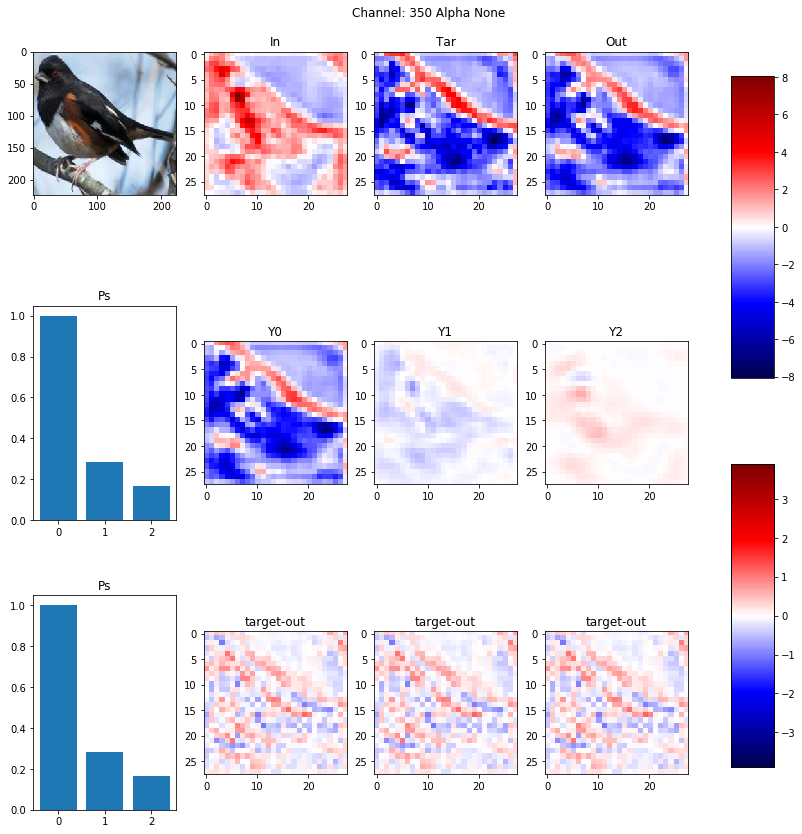

Channel:  400
[0.16494042 0.28192914]


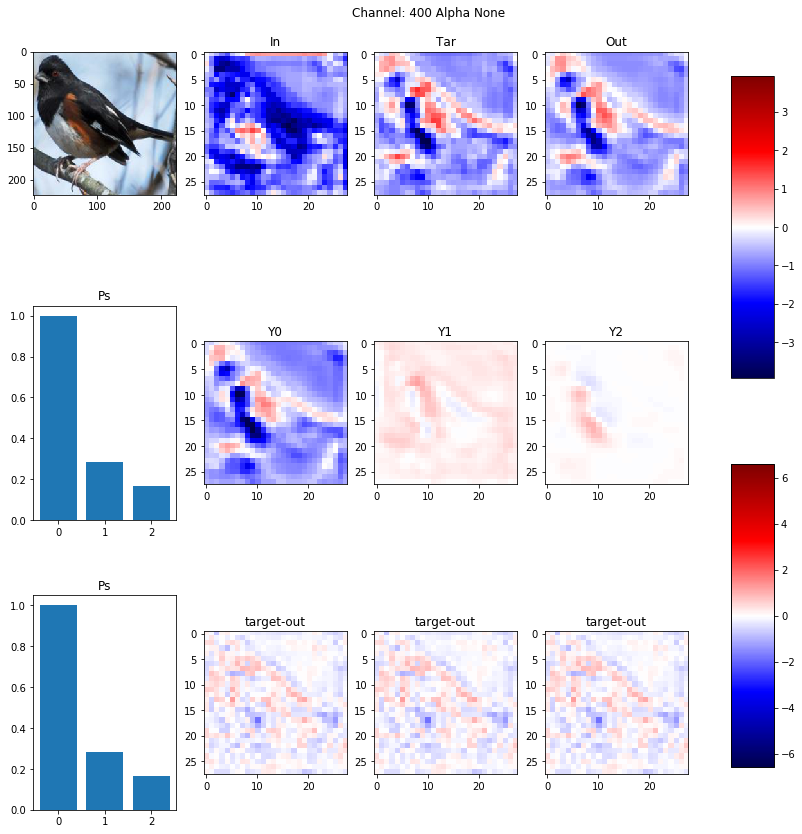

Channel:  450
[0.16494042 0.28192914]


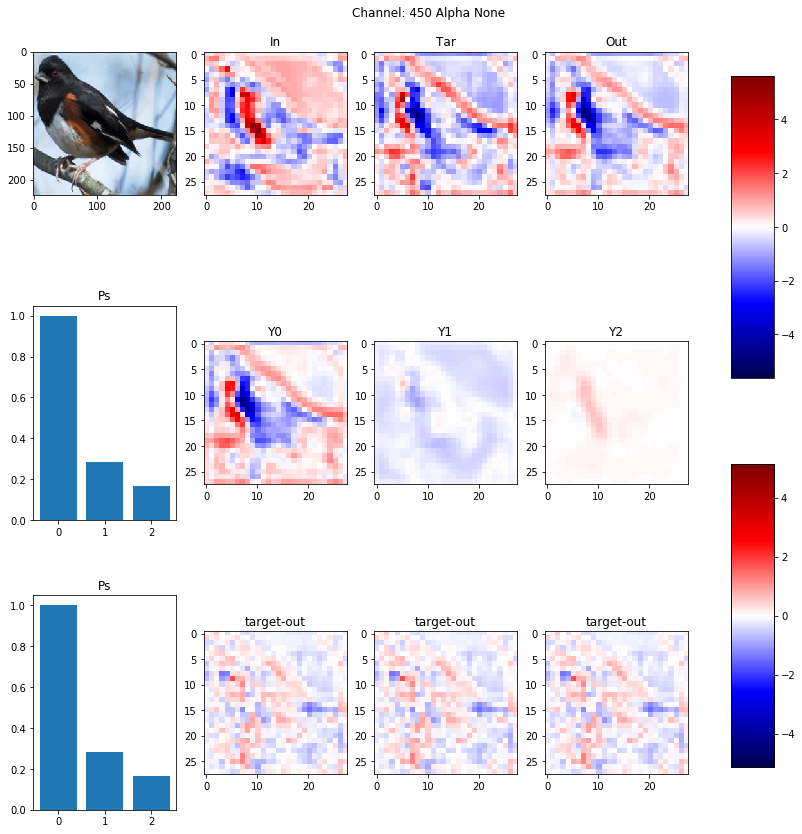

Channel:  500
[0.16494042 0.28192914]


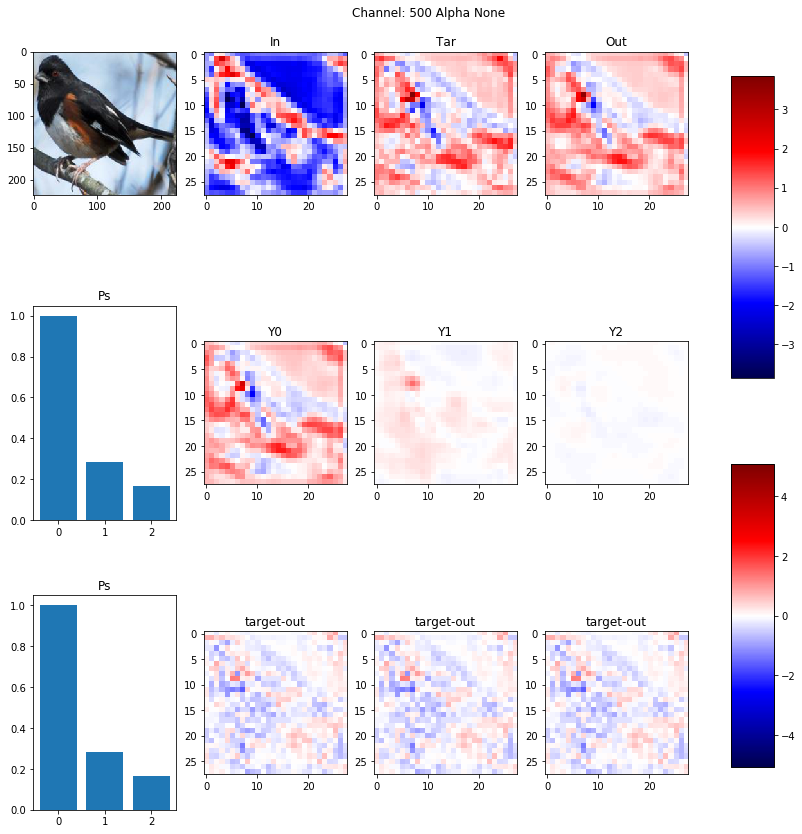

In [17]:
save_img = False  #
save_sep = False  #singal image
alpha = None
cmap = 'seismic'
remap = None
sep_bar = True
ABS = False
birds = [0,1]
for bird in birds:
    sub_img_path = "./image/CUB200_{}/{}/abs_norm/bird_{:04d}".format(arch, conv_layer, bird)
    if save_sep and not os.path.exists(sub_img_path):
        os.makedirs(sub_img_path)
    input = get_feature(image_dataset[bird][0],net1).unsqueeze(0).cuda(gpu)
    target = get_feature(image_dataset[bird][0],net2)

    output, output_n, output_contrib, res = model.val_linearity(input)
    inputs = input.cpu().squeeze(0).numpy()
    output = output.numpy()
    output_n = output_n.numpy()
    target = target.numpy()
    ps = model.get_p().data.cpu().numpy()
    delta = target - output
    if ABS:
        delta = np.abs(delta)
        inputs = np.abs(inputs)
        output = np.abs(output)
        output_n = np.abs(output_n)
        target = np.abs(target)
    vinmin = np.min(inputs)
    vinmax = np.max(inputs)
    voutmin = np.min(target)
    voutmax = np.max(target)
    if not sep_bar:
        vmin1 = np.min((inputs, output))
        vmin2 = np.min(output_n)
        vmax1 = np.max((inputs, output))
        vmax2 = np.max(output_n)

    for t in np.arange(11)*50:
        vinmin = np.abs(np.min(inputs[t]))
        vinmax = np.abs(np.max(inputs[t]))
        vinmax = max(vinmax, vinmin)
        vinmin = -vinmax
        voutmin = np.abs(np.min(target[t]))
        voutmax = np.abs(np.max(target[t]))
        voutmax = max(voutmax, voutmin)
        voutmin = -voutmax
        print("Channel: ", t)
        fig1, axes = plt.subplots(3, 4, figsize=(12, 12))
        fig1.suptitle("Channel: {:03d} Alpha {}".format(t, alpha))
        im = axes[0][0].imshow(toPIL(image_dataset[bird][0]))
        #     axes[1][0].imshow(toPIL(val_dataset[i][0]))
        im0 = axes[0][1].imshow(inputs[t], cmap=cmap, norm=remap, vmin=vinmin, vmax=vinmax)
        axes[0][1].set_title("In")
        axes[0][2].imshow(target[t], cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
        axes[0][2].set_title("Tar")
        axes[0][3].imshow(output[t], cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
        axes[0][3].set_title("Out")


        axes[1][0].bar([0, 1, 2], [1.0, *ps[::-1]], 0.8)
        print(ps)
        ylim = axes[1][0].get_ylim()
        xlim = axes[1][0].get_xlim()
        axes[1][0].set_aspect((xlim[1] - xlim[0]) / (ylim[1] - ylim[0]) * 1.5)
        axes[1][0].set_title('Ps')
        
        axes[2][0].bar([0, 1, 2], [1.0, *ps[::-1]], 0.8)
        ylim = axes[2][0].get_ylim()
        xlim = axes[2][0].get_xlim()
        axes[2][0].set_aspect((xlim[1] - xlim[0]) / (ylim[1] - ylim[0]) * 1.5)
        axes[2][0].set_title('Ps')
        for k in range(1, 4):
            im1 = axes[1][k].imshow(output_n[k - 1][t], cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
            axes[1][k].set_title("Y{}".format(k - 1))
            axes[2][k].imshow((delta)[t],cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
            axes[2][k].set_title("target-out")
        fig1.tight_layout()
        fig1.subplots_adjust(right=0.8)
        if sep_bar:
            cbar_ax1 = fig1.add_axes([0.85, 0.55, 0.05, 0.35])
            fig1.colorbar(im0, cax=cbar_ax1)
            cbar_ax2 = fig1.add_axes([0.85, 0.10, 0.05, 0.35])
            fig1.colorbar(im1, cax=cbar_ax2)
        else :
            cbar_ax2 = fig1.add_axes([0.85, 0.10, 0.05, 0.80])
            fig1.colorbar(im1, cax=cbar_ax2)
        fig1.colorbar(im1, cax=cbar_ax2)

        if save_img:
            plt.savefig(sub_img_path + '/' + "Channel_{:03d}".format(t))
        else:
            plt.show()
        plt.close()
        if save_sep: 
            fig, ax = plt.subplots()     
            plt.imshow(toPIL(image_dataset[bird][0]))
            # 去除图像周围的白边
            height, width, channels = [5,5,5]
            # 如果dpi=300，那么图像大小=height*width
            fig.set_size_inches(width, height)
            plt.gca().xaxis.set_major_locator(plt.NullLocator())
            plt.gca().yaxis.set_major_locator(plt.NullLocator())
            plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0)
            plt.margins(0,0)
            plt.xticks([])
            plt.yticks([])
            fig.savefig(sub_img_path + '/' + "bird_{:03d}".format(bird) + "_image.jpg", pad_inches=0)
            plt.imshow(inputs[t], cmap=cmap, norm=remap, vmin=vinmin, vmax=vinmax)
            # plt.suptitle("input")
            plt.savefig(sub_img_path + '/' + "channel_{:03d}".format(t) + "_input.jpg")
            plt.imshow(target[t], cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
            # plt.suptitle("target")
            plt.savefig(sub_img_path + '/' + "channel_{:03d}".format(t) + "_target.jpg")
            plt.imshow(output[t], cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
            # plt.suptitle("out")
            plt.savefig(sub_img_path + '/' + "channel_{:03d}".format(t) + "_out.jpg")
            plt.imshow(output_n[0][t], cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
            # plt.suptitle("Y0")
            plt.savefig(sub_img_path + '/' + "channel_{:03d}".format(t) + "_Y0.jpg")
            plt.imshow(output_n[1][t], cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
            # plt.suptitle("Y1")
            plt.savefig(sub_img_path + '/' + "channel_{:03d}".format(t) + "_Y1.jpg")
            plt.imshow(output_n[2][t], cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
            # plt.suptitle("Y2")
            plt.savefig(sub_img_path + '/' + "channel_{:03d}".format(t) + "_Y2.jpg")
            plt.imshow((delta)[t], cmap=cmap, norm=remap, vmin=voutmin, vmax=voutmax)
            # plt.suptitle("target-out")
            plt.savefig(sub_img_path + '/' + "channel_{:03d}".format(t) + "_target-out.jpg")
            plt.close()